# =============================================
# 간단한 데이터 사용
# (데이터는 data.csv화일 사용)

In [1]:
# 메모리에 있는 모든 변수를 지우고 새롭게 시작함
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [2]:
# 사용되는 패키지을 읽어들임
# pip install numpy pandas

import numpy as np
import pandas as pd
import random
import calendar
import matplotlib.pyplot as plt
from scipy.stats import mstats, skew, kurtosis
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.gofplots import qqline
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Colab 사용할 경우 구글드라이버 폴더에 접근하게 함
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
sdata = pd.read_csv("/gdrive//MyDrive/QuantFinance/data.csv", index_col=0)
# sdata = pd.read_csv("data.csv",index_col=0)   # 자신의 컴퓨터에 설치된 파이썬을 사용하는 경우. 파이썬 코드와 데이터 화일의 위치가 동일해야함. 아니면 폴더 경로를 명시
sdata = sdata.dropna(axis=0)   # 입력이 없는 열은 삭제함, axis=1로허면 어떻게 될까?
n = sdata.shape[0]   # 행의 수자   [1]인 경우 열의 수자

sdata.info()   # 읽어들인 데이터의 정보

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 2006-09-29 to 2020-07-31
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RKOSPI     167 non-null    float64
 1   RLotte     167 non-null    float64
 2   RManho     167 non-null    float64
 3   RMeritz    167 non-null    float64
 4   RSamsung   167 non-null    float64
 5   RSamyoung  167 non-null    float64
 6   RF_M       167 non-null    float64
 7   RFGN_REV   167 non-null    float64
 8   RIPD       167 non-null    float64
 9   RCPI       167 non-null    float64
 10  RSP500     167 non-null    float64
 11  ROil       167 non-null    float64
 12  Rshanghai  167 non-null    float64
 13  KOSPI      167 non-null    float64
 14  Lotte      167 non-null    float64
 15  Manho      167 non-null    float64
 16  Meritz     167 non-null    float64
 17  Samsung    167 non-null    float64
 18  Samyoung   167 non-null    float64
 19  rf         167 non-null    float64
 20 

In [5]:
# 추정할 파라미터를 정의
SAVG = []     # 이름만 지정된 변수
SSD = []
SSK = []
SKT = []

for i in range(1,6):     # 6 바로전까지만 선탣됨
    Y = (sdata.iloc[:,i]-sdata['RF_M']).values     # sdata의 두번째 열에서 6번째 열까지 다섯개의 주식, iloc는 수자로 행이나 열을 지정. 참고로 loc는 행이나 열의 이름(label)으로 지정. e.g., iloc[1] vs loc[A]
    SAVG.append(Y.mean())
    SSD.append(Y.std())
    SSK.append(skew(Y))
    SKT.append(kurtosis(Y))

    print(sdata.iloc[:,i].name, ":   Average Excess Return:", Y.mean(),",   STD:", Y.std(), ",   Skewness:", skew(Y), ",   Kurtosis:", kurtosis(Y))     # 결과물을 프린트함

print("데이터형식 확인")
print(SAVG)   # 데이터 형식 확인

RLotte :   Average Excess Return: -0.25456886227544906 ,   STD: 9.368235042638515 ,   Skewness: 0.26055016673779374 ,   Kurtosis: 1.0896945556972382
RManho :   Average Excess Return: 0.22197604790419156 ,   STD: 9.905914964950965 ,   Skewness: -0.20517667500253964 ,   Kurtosis: 3.779512275747652
RMeritz :   Average Excess Return: 0.8050179640718562 ,   STD: 10.3016531616024 ,   Skewness: 0.06315052317800038 ,   Kurtosis: 0.4411168277698776
RSamsung :   Average Excess Return: 0.8197065868263472 ,   STD: 7.055587748924323 ,   Skewness: 0.09021287171204823 ,   Kurtosis: -0.28134588853573517
RSamyoung :   Average Excess Return: 0.89525748502994 ,   STD: 14.88729471970734 ,   Skewness: 1.1582826725069195 ,   Kurtosis: 5.3180513552171575
데이터형식 확인
[-0.25456886227544906, 0.22197604790419156, 0.8050179640718562, 0.8197065868263472, 0.89525748502994]


In [6]:
SAVG = pd.Series(SAVG)   # series나 DataFrame 형식의 데이터만 concatenate가능
SSD = pd.Series(SSD)
SSK = pd.Series(SSK)
SKT = pd.Series(SKT)

print("데이터형식 확인")
print(SAVG)   # 데이터형식 확인

Inv_Cov = np.linalg.inv(sdata.iloc[:,1:6].cov())   # 공분산의 역행렬
InWgts = Inv_Cov@SAVG
InWgts = pd.Series(InWgts/ InWgts.sum())

df = pd.concat([SAVG, SSD, SSK, SKT, InWgts], axis=1)   # df 라는 matrix는 SAVG, SSD, SSK, SKT, InWgts 의 벡터를 순차적으로 오른편으로 덧붙여 작성. axis=0 이면 아래쪽으로 붙임
df.columns = ['SAVG', 'SSD', 'SSK', 'SKT', 'lnWgts']    # df matrix 의 열 이름 부여
df.index = sdata.columns[1:6]                           # df matrix의 행 이름은 각 주식의 회사 이름으로 부여

print("주식별 초과평균수익률, STD, 왜도, 첨도, 그리고 투자비중")     # 결과물을 프린트함
df


데이터형식 확인
0   -0.254569
1    0.221976
2    0.805018
3    0.819707
4    0.895257
dtype: float64
주식별 초과평균수익률, STD, 왜도, 첨도, 그리고 투자비중


,SAVG,SSD,SSK,SKT,lnWgts
RLotte,-0.254569,9.368235,0.260550,1.089695,-0.344333
RManho,0.221976,9.905915,-0.205177,3.779512,-0.063592
RMeritz,0.805018,10.301653,0.063151,0.441117,0.318567
RSamsung,0.819707,7.055588,0.090213,-0.281346,0.846618
RSamyoung,0.895257,14.887295,1.158283,5.318051,0.242739


# 투자비중 계산과 투자비중에 대한 통계데이터

In [7]:

corr_df = df.corr(method='pearson')     # 상관계수 pearson이 default, spearman
print("The correlation Matrix is:")
print(corr_df, "\n")


The correlation Matrix is:
            SAVG       SSD       SSK       SKT    lnWgts
SAVG    1.000000  0.278612  0.354553  0.063070  0.832501
SSD     0.278612  1.000000  0.814346  0.838523 -0.252777
SSK     0.354553  0.814346  1.000000  0.572381  0.029541
SKT     0.063070  0.838523  0.572381  1.000000 -0.350757
lnWgts  0.832501 -0.252777  0.029541 -0.350757  1.000000 



# 시장포트폴리오의 수익율 예측

                            OLS Regression Results                            
Dep. Variable:                 RKOSPI   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     30.43
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           2.04e-26
Time:                        05:23:07   Log-Likelihood:                -440.26
No. Observations:                 167   AIC:                             896.5
Df Residuals:                     159   BIC:                             921.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3372      0.634     -0.532      0.5

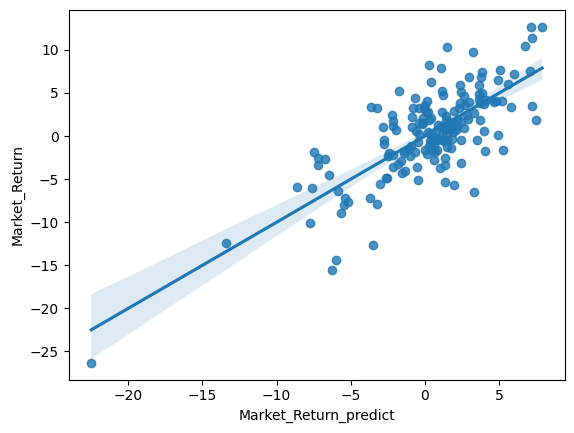

In [8]:
Market_return = sdata.loc[:,'RKOSPI']       # sdata.iloc[:,0]  혹은 sdata.loc[:,'RKOSPI']
x = sdata.loc[:,['RF_M','RFGN_REV','RIPD','RCPI','RSP500','ROil','Rshanghai']]
model = sm.OLS(Market_return, sm.add_constant(x))
result = model.fit()
print(result.summary())

Market_return_predict = result.predict()

sns.regplot(x=Market_return_predict,
            y=Market_return,
            fit_reg=True) # default, False로하면 회귀선이 표기되지 않음
plt.xlabel("Market_Return_predict")
plt.ylabel("Market_Return")

plt.show()

데이터형식 확인
0       1.371
1      -0.501
2       4.839
3       0.157
4      -5.313
        ...  
162   -12.437
163    10.431
164     4.126
165     3.806
166     6.475
Name: RKOSPI, Length: 167, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 RKOSPI   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.060
Date:                Sat, 23 Sep 2023   Prob (F-statistic):              0.392
Time:                        05:23:12   Log-Likelihood:                -504.85
No. Observations:                 166   AIC:                             1026.
Df Residuals:                     158   BIC:                             1051.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
     

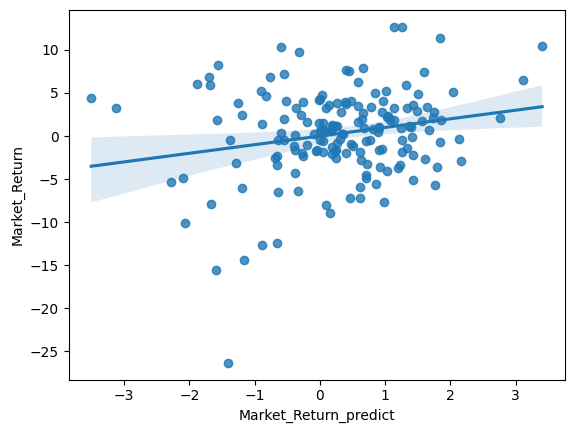

In [9]:
Market_return = Market_return.reset_index(drop =True)  # reset_index는 인덱스를 무시. drop =True는 기존 인덱스를 없애라는 의미
print("데이터형식 확인")
print(Market_return)

# One Month Ahead Forecast
X1 = x.iloc[:-1,:].dropna(axis =0).reset_index(drop =True)  # 맨 마지막 관찰치[-1], 0부터 마지막 전까지 포함
Y1 = Market_return[1:].reset_index(drop =True)              # 첫번째 관찰치[0] 없애기, 1부터 전부 포함
model = sm.OLS(Y1,sm.add_constant(X1))
result = model.fit()
print(result.summary())

Market_return_predict1 = result.predict()

sns.regplot(x=Market_return_predict1,
            y=Y1,
            fit_reg=True) # default
plt.xlabel("Market_Return_predict")
plt.ylabel("Market_Return")

plt.show()


                            OLS Regression Results                            
Dep. Variable:                 RKOSPI   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     4.068
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           0.000397
Time:                        05:23:20   Log-Likelihood:                -492.33
No. Observations:                 165   AIC:                             1001.
Df Residuals:                     157   BIC:                             1026.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0697      0.918      2.256      0.0

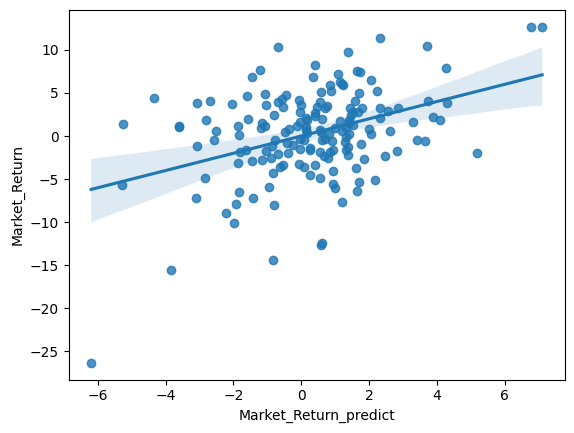

In [10]:
# Two Month Ahead Forecast
X2 = x.iloc[:-2,:].dropna(axis =0).reset_index(drop =True)
Y2 = Market_return[2:].reset_index(drop =True)
model = sm.OLS(Y2,sm.add_constant(X2))
result = model.fit()
print(result.summary())

Market_return_predict2 = result.predict()

sns.regplot(x=Market_return_predict2,
            y=Y2,
            fit_reg=True) # default
plt.xlabel("Market_Return_predict")
plt.ylabel("Market_Return")

plt.show()


                            OLS Regression Results                            
Dep. Variable:                 RKOSPI   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.156
Date:                Sat, 23 Sep 2023   Prob (F-statistic):             0.0410
Time:                        05:23:27   Log-Likelihood:                -495.56
No. Observations:                 164   AIC:                             1007.
Df Residuals:                     156   BIC:                             1032.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8469      0.978      0.866      0.3

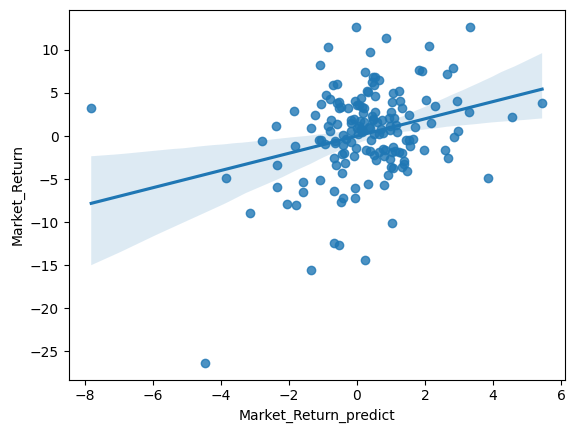

In [11]:
# Three Month Ahead Forecast
X3 = x.iloc[:-3,:].dropna(axis =0).reset_index(drop =True)
Y3 = Market_return[3:].reset_index(drop =True)
model = sm.OLS(Y3,sm.add_constant(X3))
result = model.fit()
print(result.summary())

Market_return_predict3 = result.predict()

sns.regplot(x=Market_return_predict3,
            y=Y3,
            fit_reg=True) # default
plt.xlabel("Market_Return_predict")
plt.ylabel("Market_Return")

plt.show()


# Explanation of the Market Index (Spurious regression or Cointegration)

                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     148.4
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           2.43e-66
Time:                        05:23:32   Log-Likelihood:                -1018.7
No. Observations:                 167   AIC:                             2053.
Df Residuals:                     159   BIC:                             2078.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        126.9382    452.830      0.280      0.7

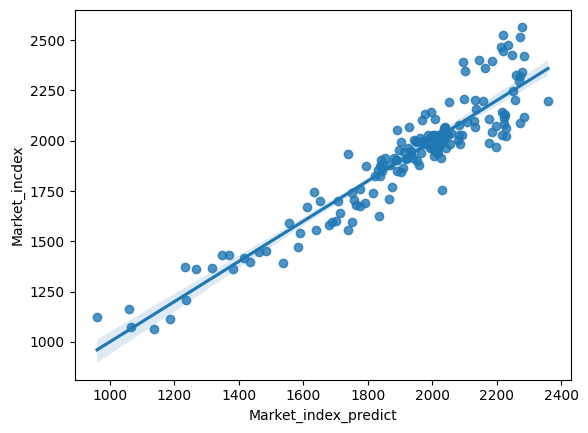

In [12]:
Market_index = sdata.loc[:,'KOSPI']
IX= sdata.loc[:,['RF_M','FGN_REV','IPD','CPI','SP500','Oil','Shanghai']]
I_Reg_M = sm.OLS(Market_index ,sm.add_constant(IX))
I_Reg_M_fit = I_Reg_M.fit()
print(I_Reg_M_fit.summary())

Market_index_predict = I_Reg_M_fit.predict()

sns.regplot(x=Market_index_predict,
            y=Market_index,
            fit_reg=True) # default
plt.xlabel("Market_index_predict")
plt.ylabel("Market_incdex")

plt.show()


                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     93.80
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           5.54e-53
Time:                        05:23:43   Log-Likelihood:                -1042.8
No. Observations:                 166   AIC:                             2102.
Df Residuals:                     158   BIC:                             2126.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        748.5978    546.603      1.370      0.1

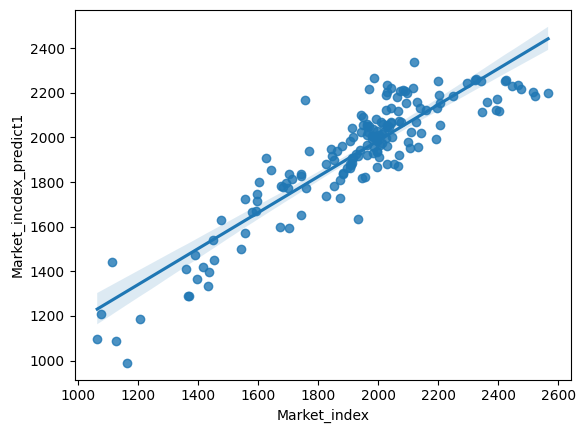

In [13]:
# One Month Ahead Forecast
Market_index1 = Market_index[1:].reset_index(drop =True)
IX1 = IX.iloc[:-1,:].dropna(axis =0).reset_index(drop =True)
I_Reg_M1 = sm.OLS(Market_index1 ,sm.add_constant(IX1))
I_Reg_M1_fit = I_Reg_M1.fit()
print(I_Reg_M1_fit.summary())

Market_index_predict1 = I_Reg_M1_fit.predict()

sns.regplot(x=Market_index1,
            y=Market_index_predict1,
            fit_reg=True) # default
plt.xlabel("Market_index")
plt.ylabel("Market_incdex_predict1")

plt.show()

                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     69.13
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           9.60e-45
Time:                        05:24:00   Log-Likelihood:                -1054.4
No. Observations:                 165   AIC:                             2125.
Df Residuals:                     157   BIC:                             2150.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1145.6345    612.865      1.869      0.0

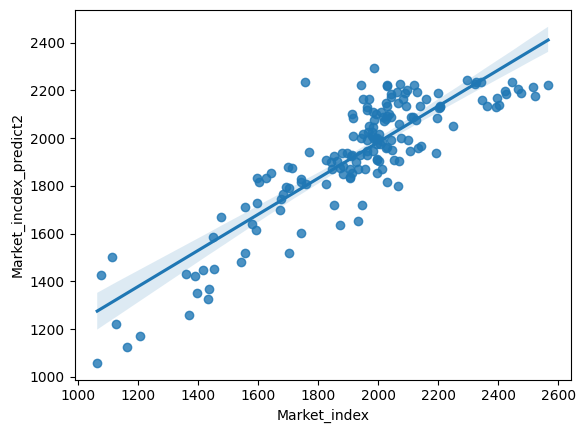

In [15]:
# Two Month Ahead Forecast
Market_index2 = Market_index[2:].reset_index(drop =True)
IX2 = IX.iloc[:-2,:].dropna(axis =0).reset_index(drop =True)
I_Reg_M2 = sm.OLS(Market_index2 ,sm.add_constant(IX2))
I_Reg_M2_fit = I_Reg_M2.fit()
print(I_Reg_M2_fit.summary())
Market_index_predict2 = I_Reg_M2_fit.predict()


sns.regplot(x=Market_index2,
            y=Market_index_predict2,
            fit_reg=True) # default
plt.xlabel("Market_index")
plt.ylabel("Market_incdex_predict2")

plt.show()

                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     54.21
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           1.22e-38
Time:                        05:24:07   Log-Likelihood:                -1061.2
No. Observations:                 164   AIC:                             2138.
Df Residuals:                     156   BIC:                             2163.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1530.5620    666.039      2.298      0.0

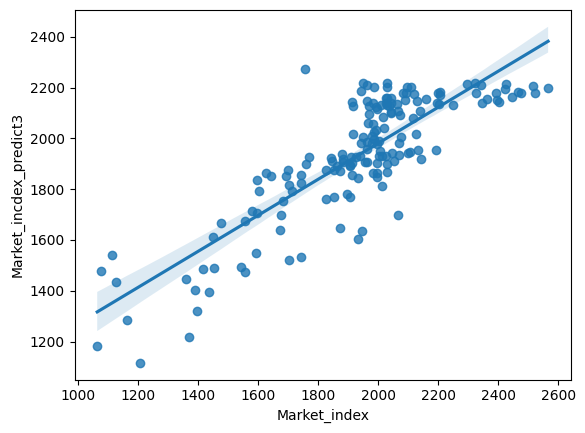

In [16]:
# Three Month Ahead Forecast
Market_index3 = Market_index[3:].reset_index(drop =True)
IX3 = IX.iloc[:-3,:].dropna(axis =0).reset_index(drop =True)
I_Reg_M3 = sm.OLS(Market_index3 ,sm.add_constant(IX3))
I_Reg_M3_fit = I_Reg_M3.fit()
print(I_Reg_M3_fit.summary())
Market_index_predict3 = I_Reg_M3_fit.predict()


sns.regplot(x=Market_index3,
            y=Market_index_predict3,
            fit_reg=True) # default
plt.xlabel("Market_index")
plt.ylabel("Market_incdex_predict3")

plt.show()

# ================================================
# 모든 상장회사
# 데이터는 QuantDataR.xlsx 사용

In [17]:
# 메모리에 있는 모든 변수를 지우고 새롭게 시작함
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [18]:
# 사용되는 패키지을 읽어들임
import numpy as np
import pandas as pd
import random
import calendar
import matplotlib.pyplot as plt
from scipy.stats import mstats, skew, kurtosis
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.gofplots import qqline
import math
import warnings
warnings.filterwarnings('ignore')

In [19]:
# 시장수익률과 무위험자산 수익률을 읽음
sdata = pd.read_csv("/gdrive//MyDrive/QuantFinance/data.csv", index_col=0)
# sdata = pd.read_csv("data.csv",index_col=0)   # 자신의 컴퓨터에 설치된 파이썬을 사용하는 경우. 파이썬 코드와 데이터 화일의 위치가 동일해야함. 아니면 폴더 경로를 명시

sdata.index = pd.to_datetime(sdata.index)
#sdata = sdata.dropna(axis=0).drop('Dates', axis=1).reset_index(drop =True)
n = sdata.shape[0]
MR = sdata['RKOSPI']
RF = sdata['RF_M']

MR = MR[1:168]
RF = RF[1:168]

print("데이터형식 확인")
print(RF)

데이터형식 확인
Dates
2006-09-29    0.373
2006-10-31    0.373
2006-11-30    0.373
2006-12-29    0.374
2007-01-31    0.386
              ...  
2020-03-31    0.083
2020-04-30    0.062
2020-05-29    0.058
2020-06-30    0.040
2020-07-31    0.040
Name: RF_M, Length: 167, dtype: float64


In [20]:
# 개별자산 데이터, 전체 데이터 읽음  다소 시간이 많이 걸림 (2분 정도)
#data= 'QuantDataR.xlsx'
#df = pd.read_excel(data, None, index_col=0 )  # 자신의 컴퓨터에 설치된 파이썬을 사용하는 경우. 파이썬 코드와 데이터 화일의 위치가 동일해야함. 아니면 폴더 경로를 명시
df = pd.read_excel("/gdrive//MyDrive/QuantFinance/QuantDataR.xlsx", None, index_col=0 )
df_names = list(df.keys())

print("==========================================================================")
print("Spreadsheet 확인")
print(df_names)

Spreadsheet 확인
['D_Market', 'D_RI', 'D_TradingValue', 'D_P', 'M_Market', 'Beta', 'Volatility', 'DY', 'RI', 'TradingValue', 'Cash', 'AccReceivables', 'Inventory', 'CurrentAsset', 'R&D', 'Plants', 'Intangible', 'Total Asset', 'AccPayable', 'CurrentLiability', 'LongTermDebt', 'TotalLiability', 'CommonEquity', 'TotalShareEqu', 'Sales', 'CoGS', 'DepArm', 'OperatingIncome', 'EBIT', 'Interest', 'NetIncome', 'DividendPerShare', 'EPS', 'CommonShares', 'Investment', 'Employee', 'WorkingCap', 'MarketValue']


In [21]:
# 개별주식의 총수익률 (RI) 데이터 읽음
RID = df['RI']
RID = RID.iloc[0:168,:]
print("--------------------------------------------------------------------------")
print("데이터형식 확인")
print(RID)

# Dates
date = RID.index
print("--------------------------------------------------------------------------")
print("Dates")
print(date)

#firm names using 'D_Price'  이름 이외에는 다른 군더기가 없음 ㅎ
D_Price = df['D_P']
firm_names =  D_Price.columns
print("--------------------------------------------------------------------------")
print("FIrm Names")
print(firm_names)

--------------------------------------------------------------------------
데이터형식 확인
            A SELF-ADMINISTERED REIT.TST. - TOT RETURN IND  \
Name                                                         
2006-08-31                                             NaN   
2006-09-29                                             NaN   
2006-10-31                                             NaN   
2006-11-30                                             NaN   
2006-12-29                                             NaN   
...                                                    ...   
2020-03-31                                          142.09   
2020-04-30                                          148.71   
2020-05-29                                          171.99   
2020-06-30                                          167.76   
2020-07-31                                          170.41   

            ABLE C&C - TOT RETURN IND  AEKYUNG IND - TOT RETURN IND  \
Name                                  

In [22]:
############################################################################################
# Calculation of log-returns

R = []
print("Null stocks: ", end ='')    # end=''  다음 출력이 같은 줄에 프린트하기
for i in range(0,RID.shape[1]):

    if RID.shape[0] - RID.iloc[:, i ].isnull().sum() < 2:   # 전체 T개의 관찰치중 NA개수를 뺀 나머지가 2 보다 작으면 계산하지 않음

        print (i, ", ", end='')
        R_temp = pd.Series([np.nan]*(RID.shape[0]-1))    #전체를 NA로 대체
        R.append(R_temp)
        continue            # 반복문 내에서만 사용되며, 반복이 진행되는 도중 continue문을 만나면 반복문의 끝으로 이동하여 다음 반복문(i+1)으로 넘어감.

    log0 = (np.log(RID.iloc[1:, i ])).reset_index(drop =True)
    log1 = (np.log(RID.iloc[0:-1, i ])).reset_index(drop =True)

    R_temp =  (log0-log1)*100
    R.append(R_temp)

print(sep ='')

R = pd.concat(R,axis= 1)   # R이라는 matrix는 각 개별주식의 수익률 벡터를 순차적으로 오른편으로 덧붙여 작성. axis=0 이면 아래쪽으로 붙임
R.index = date[1:]         # 첫달 제외
R.columns = firm_names     # 회사이름

print("=========================================================================")
print("Return Data")
print(R)

Null stocks: 25 , 333 , 334 , 374 , 416 , 521 , 694 , 747 , 
Return Data
            A SELF-ADMINISTERED REIT.TST.   ABLE C&C  AEKYUNG IND  AIR BUSAN  \
Name                                                                           
2006-09-29                            NaN   4.372000          NaN        NaN   
2006-10-31                            NaN  24.040686          NaN        NaN   
2006-11-30                            NaN -13.268377          NaN        NaN   
2006-12-29                            NaN  -9.720986          NaN        NaN   
2007-01-31                            NaN -14.786239          NaN        NaN   
...                                   ...        ...          ...        ...   
2020-03-31                      -9.755336 -23.177143   -10.758720 -31.234498   
2020-04-30                       4.553744  23.177143    20.286260  28.275434   
2020-05-29                      14.543823  -9.827651   -13.454202  -3.198141   
2020-06-30                      -2.490195   0.8

In [23]:
# Choose one date for testing
# rndate = random.randint(62,len(date)-59)   #Randomly Selecting a month from 2011 excluding 2016 and onword
rndate = 74

print("--------------------------------------------------------------------------")
print("Selected Date")
print(R.index[rndate]) #Print the selected month


--------------------------------------------------------------------------
Selected Date
2012-11-30 00:00:00


In [24]:
MR_s = MR[rndate :  rndate+60]   #.reset_index(drop =True)
RF_s = RF[rndate :  rndate+60]   #.reset_index(drop =True)

R_test  =  R.iloc[rndate :  rndate+60,:]
Sdate = R_test.index

# Remove firms whose returns are not available
R_test = R_test.dropna(axis= 1)

print("-------------------------------------------------------------------------")
print("Selected Returns")
print(R_test)


-------------------------------------------------------------------------
Selected Returns
            A SELF-ADMINISTERED REIT.TST.   ABLE C&C  AJU CAPITAL  \
Name                                                                
2012-11-30                      -5.671765  -6.366568    -5.874694   
2012-12-31                      -0.710735   2.421138     3.963678   
2013-01-31                      -8.124409  -3.744091    -0.617667   
2013-02-28                       1.031334  -4.715786     7.261200   
2013-03-29                      -3.411280  17.076162     9.239592   
2013-04-30                       3.411280 -35.832378     5.286222   
2013-05-31                       8.748345 -27.284043    12.943988   
2013-06-28                       1.531637 -12.187634    -2.143642   
2013-07-31                     -19.884533  -8.497000    -3.695313   
2013-08-30                      16.211426  -6.238880    -6.707198   
2013-09-30                      -9.875648  17.777597     0.506052   
2013-10-31  

In [25]:
R_Excess = pd.DataFrame(np.empty((R_test.shape[0],R_test.shape[1]))*np.nan, columns = R_test.columns, index=Sdate)

for i in range(0,R_test.shape[1]):

    R_Excess.iloc[:,i] = (R_test.iloc[:,i]-RF_s) # excess returns of individual stocks


Inv_Cov = np.linalg.inv(R_Excess.cov())   # 공분산의 역행렬
InWgts = Inv_Cov@R_Excess.mean()
InWgts = pd.Series(InWgts/ InWgts.sum())
InWgts.index = R_test.columns

df = pd.concat([R_Excess.mean(), R_Excess.std(),InWgts], axis=1)   # df 라는 matrix는 SAVG, SSD, SSK, SKT, InWgts 의 벡터를 순차적으로 오른편으로 덧붙여 작성. axis=0 이면 아래쪽으로 붙임
df.columns = ['SAVG', 'SSD', 'lnWgts']    # df matrix 의 열 이름 부여

print("주식별 초과평균수익률, STD, 그리고 투자비중")     # 결과물을 프린트함
df

주식별 초과평균수익률, STD, 그리고 투자비중


,SAVG,SSD,lnWgts
A SELF-ADMINISTERED REIT.TST.,0.512353,7.232893,-0.468714
ABLE C&C,-1.731490,15.776629,0.085178
AJU CAPITAL,1.423416,6.104341,0.616507
AK HOLDINGS,1.796921,11.987623,-0.063214
AK PETROCHEMICAL,1.652632,8.993736,0.367463
...,...,...,...
YUHAN,0.110431,8.813107,-0.060106
YUHWA SECURITIES,0.742629,3.087959,0.458671
YUNGJIN PHARM,2.415535,16.782549,0.008477
YUYANG D&U SUSP - SUSP.20/03/20,2.580230,14.964445,0.050549


In [26]:

corr_df = df.corr(method='pearson')     # 상관계수 pearson이 default, spearman
print("The correlation Matrix is:")
print(corr_df, "\n")

The correlation Matrix is:
            SAVG       SSD    lnWgts
SAVG    1.000000 -0.299260  0.004935
SSD    -0.299260  1.000000 -0.019342
lnWgts  0.004935 -0.019342  1.000000 



=====================
과제 I : 평균분산분석
=====================
퀀트 데이터에서 2005년부터 2020년까지 이 전체 기간 동안 수익률이 있는 주식 10개를 임으로 고른 다음 다음에 답하시오.
기대수익률 (기대부)를 극대화할 경우 최적 포트폴리오는? 분석에 필요한 가정은 무엇인가요?
평균분산분석에 의한 최적 포트폴리오는?
    무위험자산 수익률이 증가 혹은 감소할 경우 투자비중은?
    2005년부터 5년간 데이터를 사용한 최적 포트폴리오와 2015년 부터  5년간 데이터를 사용한 최적 포트폴리오의 차이는?
    투자비중과 수익률 그리고 투자비중과 수익률의 표준편차 간의 관계를 설명하시오.
    이 분석방법의 문제점은 무엇이고 개선할 수 있는 방법은?
이 분석을 2012년 1월부터 과거 5년간의 데이터를 활용하여 매월 3년간 진행하고 투자비중이 어떻게 변하는지 분석하시오.
평균분산분석에 의하면 투자자는 시장포트폴리오와 무위험 자산에만 투자를 하게 된다.
    퀀트금융에 있는 월별 수익률데이터를 활용하여, 시장포트폴리오의 수익률을 예측하고, 수익률 예측이 가능한지에 대하여 검토하시오.
    무위험자산의 수익률은 왜 예측할 필요가 없는가?